<a href="https://colab.research.google.com/github/Zhalil24/BreastMRI-CNN-Classification/blob/main/MobileNetV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                             roc_curve, accuracy_score, precision_score, recall_score, f1_score)
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

# 1. GPU / CUDA Ayarı
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Sistem: {device} üzerinde çalışıyor.")

Sistem: cuda:0 üzerinde çalışıyor.


In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
!cp "/content/drive/MyDrive/data_set_zip/breast_mri_dataset.rar" /content/
!unrar x /content/breast_mri_dataset.rar /content/

Görüntülenen çıkış son 5000 satıra kısaltıldı.
Extracting  /content/breast_mri_dataset/train/Malignant/BREASTDX-01-0065_7848.jpg      78%  OK 
Extracting  /content/breast_mri_dataset/train/Malignant/BREASTDX-01-0065_7904.jpg      78%  OK 
Extracting  /content/breast_mri_dataset/train/Malignant/BREASTDX-01-0065_8003.jpg      78%  OK 
Extracting  /content/breast_mri_dataset/train/Malignant/BREASTDX-01-0065_8061.jpg      78%  OK 
Extracting  /content/breast_mri_dataset/train/Malignant/BREASTDX-01-0065_8253.jpg      78%  OK 
Extracting  /content/breast_mri_dataset/train/Malignant/BREASTDX-01-0065_8422.jpg      78%  OK 
Extracting  /content/breast_mri_dataset/train/Malignant/BREASTDX-01-0065_8489.jpg      78%  OK 
Extracting  /content/breast_mri_dataset/train/Malignant/BREASTDX-01-0065_8575.jpg      78%  OK 
Extracting  /content/breast_mri_dataset/train/Malignant/BREASTDX-01-0065_8605.jpg      78%  OK 
Extracti

In [21]:

data_dir = '/content/breast_mri_dataset'

In [22]:
# 3. Veri Artırma (Data Augmentation) ve Ön İşleme
mri_mean = [0.485, 0.456, 0.406]
mri_std = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05), scale=(0.95, 1.05)),
    transforms.ColorJitter(brightness=0.15, contrast=0.15),
    transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0)),
    transforms.ToTensor(),
    transforms.Normalize(mri_mean, mri_std)
])

val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mri_mean, mri_std)
])

In [23]:
# 4. MobileNetV2 Modelini Yapılandırma
def build_mobilenet_model():
    model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)

    for i, child in enumerate(model.features):
        if i <= 6:
            for param in child.parameters():
                param.requires_grad = False
        else:
            for param in child.parameters():
                param.requires_grad = True

    num_ftrs = model.classifier[1].in_features
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2),
        nn.Linear(num_ftrs, 2)
    )
    return model.to(device)

In [24]:
# 5. Diferansiyel Öğrenme Oranı (Differential Learning Rate)
def get_optimizer(model):
    optimizer = optim.Adam([
        {'params': model.features[7:10].parameters(), 'lr': 1e-5},
        {'params': model.features[10:14].parameters(), 'lr': 5e-5},
        {'params': model.features[14:19].parameters(), 'lr': 1e-4},
        {'params': model.classifier.parameters(), 'lr': 1e-3}
    ])
    return optimizer

In [25]:
# 6. Eğitim Fonksiyonu
def train_one_fold(fold, train_loader, val_loader, epochs=10):
    model = build_mobilenet_model()
    optimizer = get_optimizer(model)
    criterion = nn.CrossEntropyLoss()

    history = {'t_loss': [], 't_acc': [], 'v_loss': [], 'v_acc': []}

    for epoch in range(epochs):
        model.train()
        r_loss, r_corr = 0.0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            r_loss += loss.item() * inputs.size(0)
            r_corr += torch.sum(preds == labels.data)

        train_loss = r_loss / len(train_loader.dataset)
        train_acc = r_corr.double() / len(train_loader.dataset)

        # Validation
        model.eval()
        v_loss, v_corr = 0.0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                v_loss += loss.item() * inputs.size(0)
                v_corr += torch.sum(preds == labels.data)

        val_loss = v_loss / len(val_loader.dataset)
        val_acc = v_corr.double() / len(val_loader.dataset)

        print(f"Fold {fold} Ep {epoch+1}: T_Loss: {train_loss:.4f} T_Acc: {train_acc:.4f} | V_Loss: {val_loss:.4f} V_Acc: {val_acc:.4f}")

        history['t_loss'].append(train_loss)
        history['t_acc'].append(train_acc.item())
        history['v_loss'].append(val_loss)
        history['v_acc'].append(val_acc.item())

    return model, history

In [26]:
# 7. 5-Fold Stratified Cross-Validation ve Eğitim Başlatma
full_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=train_transforms)
labels = full_dataset.targets
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

fold_results = []
best_model = None

for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(labels)), labels)):
    print(f"\n--- FOLD {fold+1} / 5 ---")

    train_sub = Subset(full_dataset, train_idx)

    val_dataset_raw = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=val_test_transforms)
    val_sub = Subset(val_dataset_raw, val_idx)

    train_loader = DataLoader(train_sub, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_sub, batch_size=32, shuffle=False)

    model, history = train_one_fold(fold+1, train_loader, val_loader)
    fold_results.append(history)
    best_model = model


--- FOLD 1 / 5 ---
Fold 1 Ep 1: T_Loss: 0.4802 T_Acc: 0.7546 | V_Loss: 0.2656 V_Acc: 0.8827
Fold 1 Ep 2: T_Loss: 0.2913 T_Acc: 0.8665 | V_Loss: 0.1984 V_Acc: 0.9127
Fold 1 Ep 3: T_Loss: 0.2307 T_Acc: 0.8970 | V_Loss: 0.1383 V_Acc: 0.9433
Fold 1 Ep 4: T_Loss: 0.1798 T_Acc: 0.9238 | V_Loss: 0.1152 V_Acc: 0.9507
Fold 1 Ep 5: T_Loss: 0.1626 T_Acc: 0.9307 | V_Loss: 0.0941 V_Acc: 0.9614
Fold 1 Ep 6: T_Loss: 0.1311 T_Acc: 0.9455 | V_Loss: 0.0821 V_Acc: 0.9638
Fold 1 Ep 7: T_Loss: 0.1234 T_Acc: 0.9502 | V_Loss: 0.0898 V_Acc: 0.9629
Fold 1 Ep 8: T_Loss: 0.1056 T_Acc: 0.9568 | V_Loss: 0.0789 V_Acc: 0.9700
Fold 1 Ep 9: T_Loss: 0.0990 T_Acc: 0.9585 | V_Loss: 0.0585 V_Acc: 0.9759
Fold 1 Ep 10: T_Loss: 0.0836 T_Acc: 0.9658 | V_Loss: 0.0768 V_Acc: 0.9682

--- FOLD 2 / 5 ---
Fold 2 Ep 1: T_Loss: 0.4761 T_Acc: 0.7575 | V_Loss: 0.3291 V_Acc: 0.8553
Fold 2 Ep 2: T_Loss: 0.2978 T_Acc: 0.8629 | V_Loss: 0.2819 V_Acc: 0.8883
Fold 2 Ep 3: T_Loss: 0.2278 T_Acc: 0.8964 | V_Loss: 0.1758 V_Acc: 0.9242
Fold 2 Ep 

In [27]:
# 8. Test Seti Değerlendirme
test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=val_test_transforms)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

best_model.eval()
all_preds, all_labels, all_probs = [], [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = best_model(inputs)
        probs = torch.softmax(outputs, dim=1)[:, 1]
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())


TEST SETİ PERFORMANSI
Accuracy:  0.9759
Precision: 0.9788
Recall:    0.9728
F1-Score:  0.9758
ROC-AUC:   0.9978


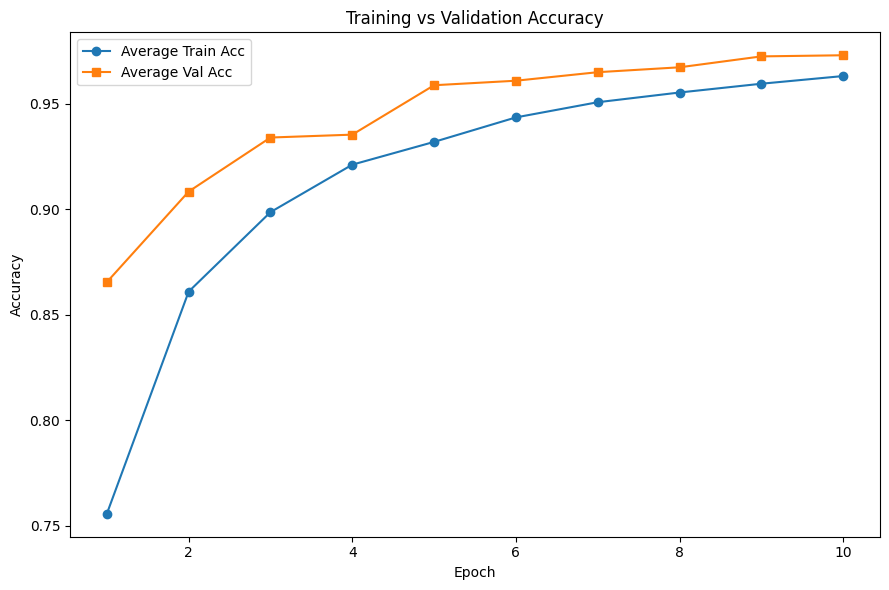

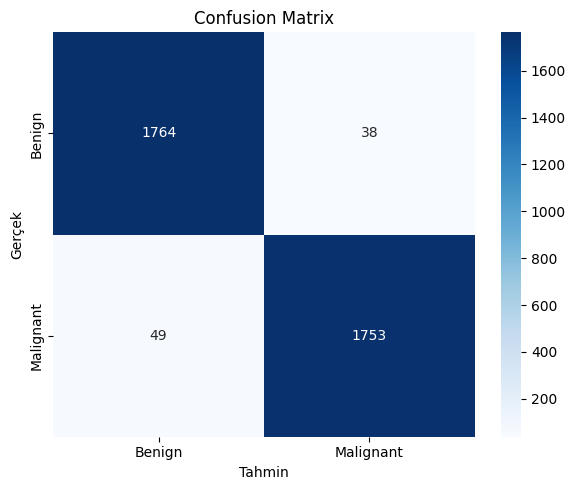

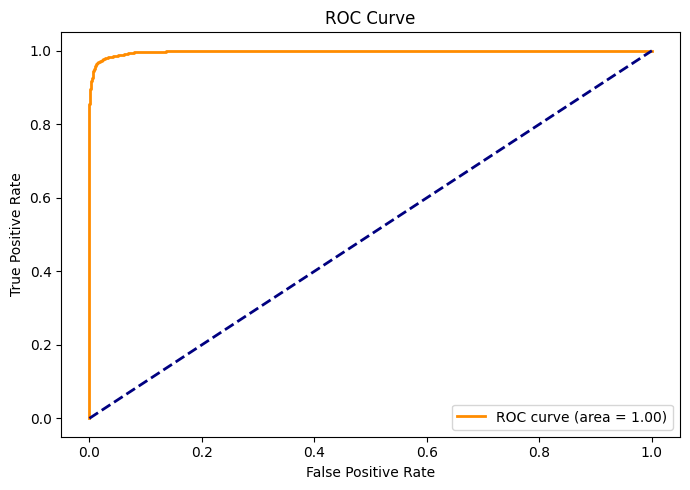

In [28]:

# 9. Metrik Hesaplama ve Görselleştirme
print("\n" + "="*30)
print("TEST SETİ PERFORMANSI")
print("="*30)
print(f"Accuracy:  {accuracy_score(all_labels, all_preds):.4f}")
print(f"Precision: {precision_score(all_labels, all_preds):.4f}")
print(f"Recall:    {recall_score(all_labels, all_preds):.4f}")
print(f"F1-Score:  {f1_score(all_labels, all_preds):.4f}")
print(f"ROC-AUC:   {roc_auc_score(all_labels, all_probs):.4f}")

num_epochs = len(fold_results[0]['t_acc'])
epochs = range(1, num_epochs + 1)

all_train_accs = np.array([res['t_acc'] for res in fold_results])
all_val_accs = np.array([res['v_acc'] for res in fold_results])
all_train_losses = np.array([res['t_loss'] for res in fold_results])
all_val_losses = np.array([res['v_loss'] for res in fold_results])

mean_train_acc = np.mean(all_train_accs, axis=0)
mean_val_acc = np.mean(all_val_accs, axis=0)
mean_train_loss = np.mean(all_train_losses, axis=0)
mean_val_loss = np.mean(all_val_losses, axis=0)

# Plot 1: Accuracy Grafiği (Tüm foldların ortalaması)
plt.figure(figsize=(9, 6))
plt.plot(epochs, mean_train_acc, label='Average Train Acc', marker='o')
plt.plot(epochs, mean_val_acc, label='Average Val Acc', marker='s')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

# Plot 2: Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.title('Confusion Matrix')
plt.ylabel('Gerçek')
plt.xlabel('Tahmin')
plt.tight_layout()
plt.show()

# Plot 3: ROC Eğrisi
fpr, tpr, _ = roc_curve(all_labels, all_probs)
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_score(all_labels, all_probs):.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()